## Figure 2B: Global distribution of viruses with clade defining substitution(s).

In [28]:
import os
import pandas as pd
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt

In [29]:
meta = pd.read_csv('../data/rawdata/nyc_omicron_metadata.csv', index_col='seqName')

In [30]:
nextclade = pd.read_csv('../data/nextclade_nyc/nextclade.tsv', delimiter='\t', index_col='seqName')

In [31]:
clades = {
    'A': [],
    'B': [],
    'C': [],
    'D': [],
    'Others': []
}
for i in nextclade.index:
    substitutions = nextclade.loc[i, 'substitutions'].split(',')
    if 'G5515T' in substitutions:
        clades['A'].append(i)
    elif 'G5924A' in substitutions:
        clades['B'].append(i)
    elif 'T10135C' in substitutions and 'C25708T' in substitutions and 'A29301G' in substitutions:
        clades['C'].append(i)
    elif 'C2470T' in substitutions and 'G22599A' in substitutions:
        clades['D'].append(i)
    else:
        clades['Others'].append(i)

In [32]:
seqs_gl = []
with open('../data/rawdata/global_sequences.fasta') as f:
    for seq_record in SeqIO.parse(f, 'fasta'):
        sequence = str(seq_record.seq)
        if sequence.count('A') + sequence.count('T') + sequence.count('G') + sequence.count('C') >= 29000:
            seqs_gl.append(seq_record.description)

meta_gl = pd.read_csv('../data/rawdata/global_metadata.tsv', delimiter='\t', index_col='strain').dropna(subset=['date', 'region_exposure', 'country_exposure', 'division_exposure'])

nextclade_gl = pd.read_csv('../data/nextclade_global/nextclade.tsv', delimiter='\t', index_col='seqName').dropna(subset=['substitutions'])
nextclade_gl = nextclade_gl[
    (nextclade_gl['qc.overallStatus'] == 'good') 
    & (nextclade_gl.index.isin(seqs_gl)) 
    & (nextclade_gl.index.isin(meta_gl.index))
    ]

In [33]:
clades_gl = {
    'A': [],
    'B': [],
    'C': [],
    'D': []
}

for i in nextclade_gl.index:
    substitutions = nextclade_gl.loc[i, 'substitutions'].split(',')
    if 'G5515T' in substitutions:
        clades_gl['A'].append(i)
    if 'G5924A' in substitutions:
        clades_gl['B'].append(i)
    if 'T10135C' in substitutions and 'C25708T' in substitutions and 'A29301G' in substitutions:
        clades_gl['C'].append(i)
    if 'C2470T' in substitutions and 'G22599A' in substitutions:
        clades_gl['D'].append(i)

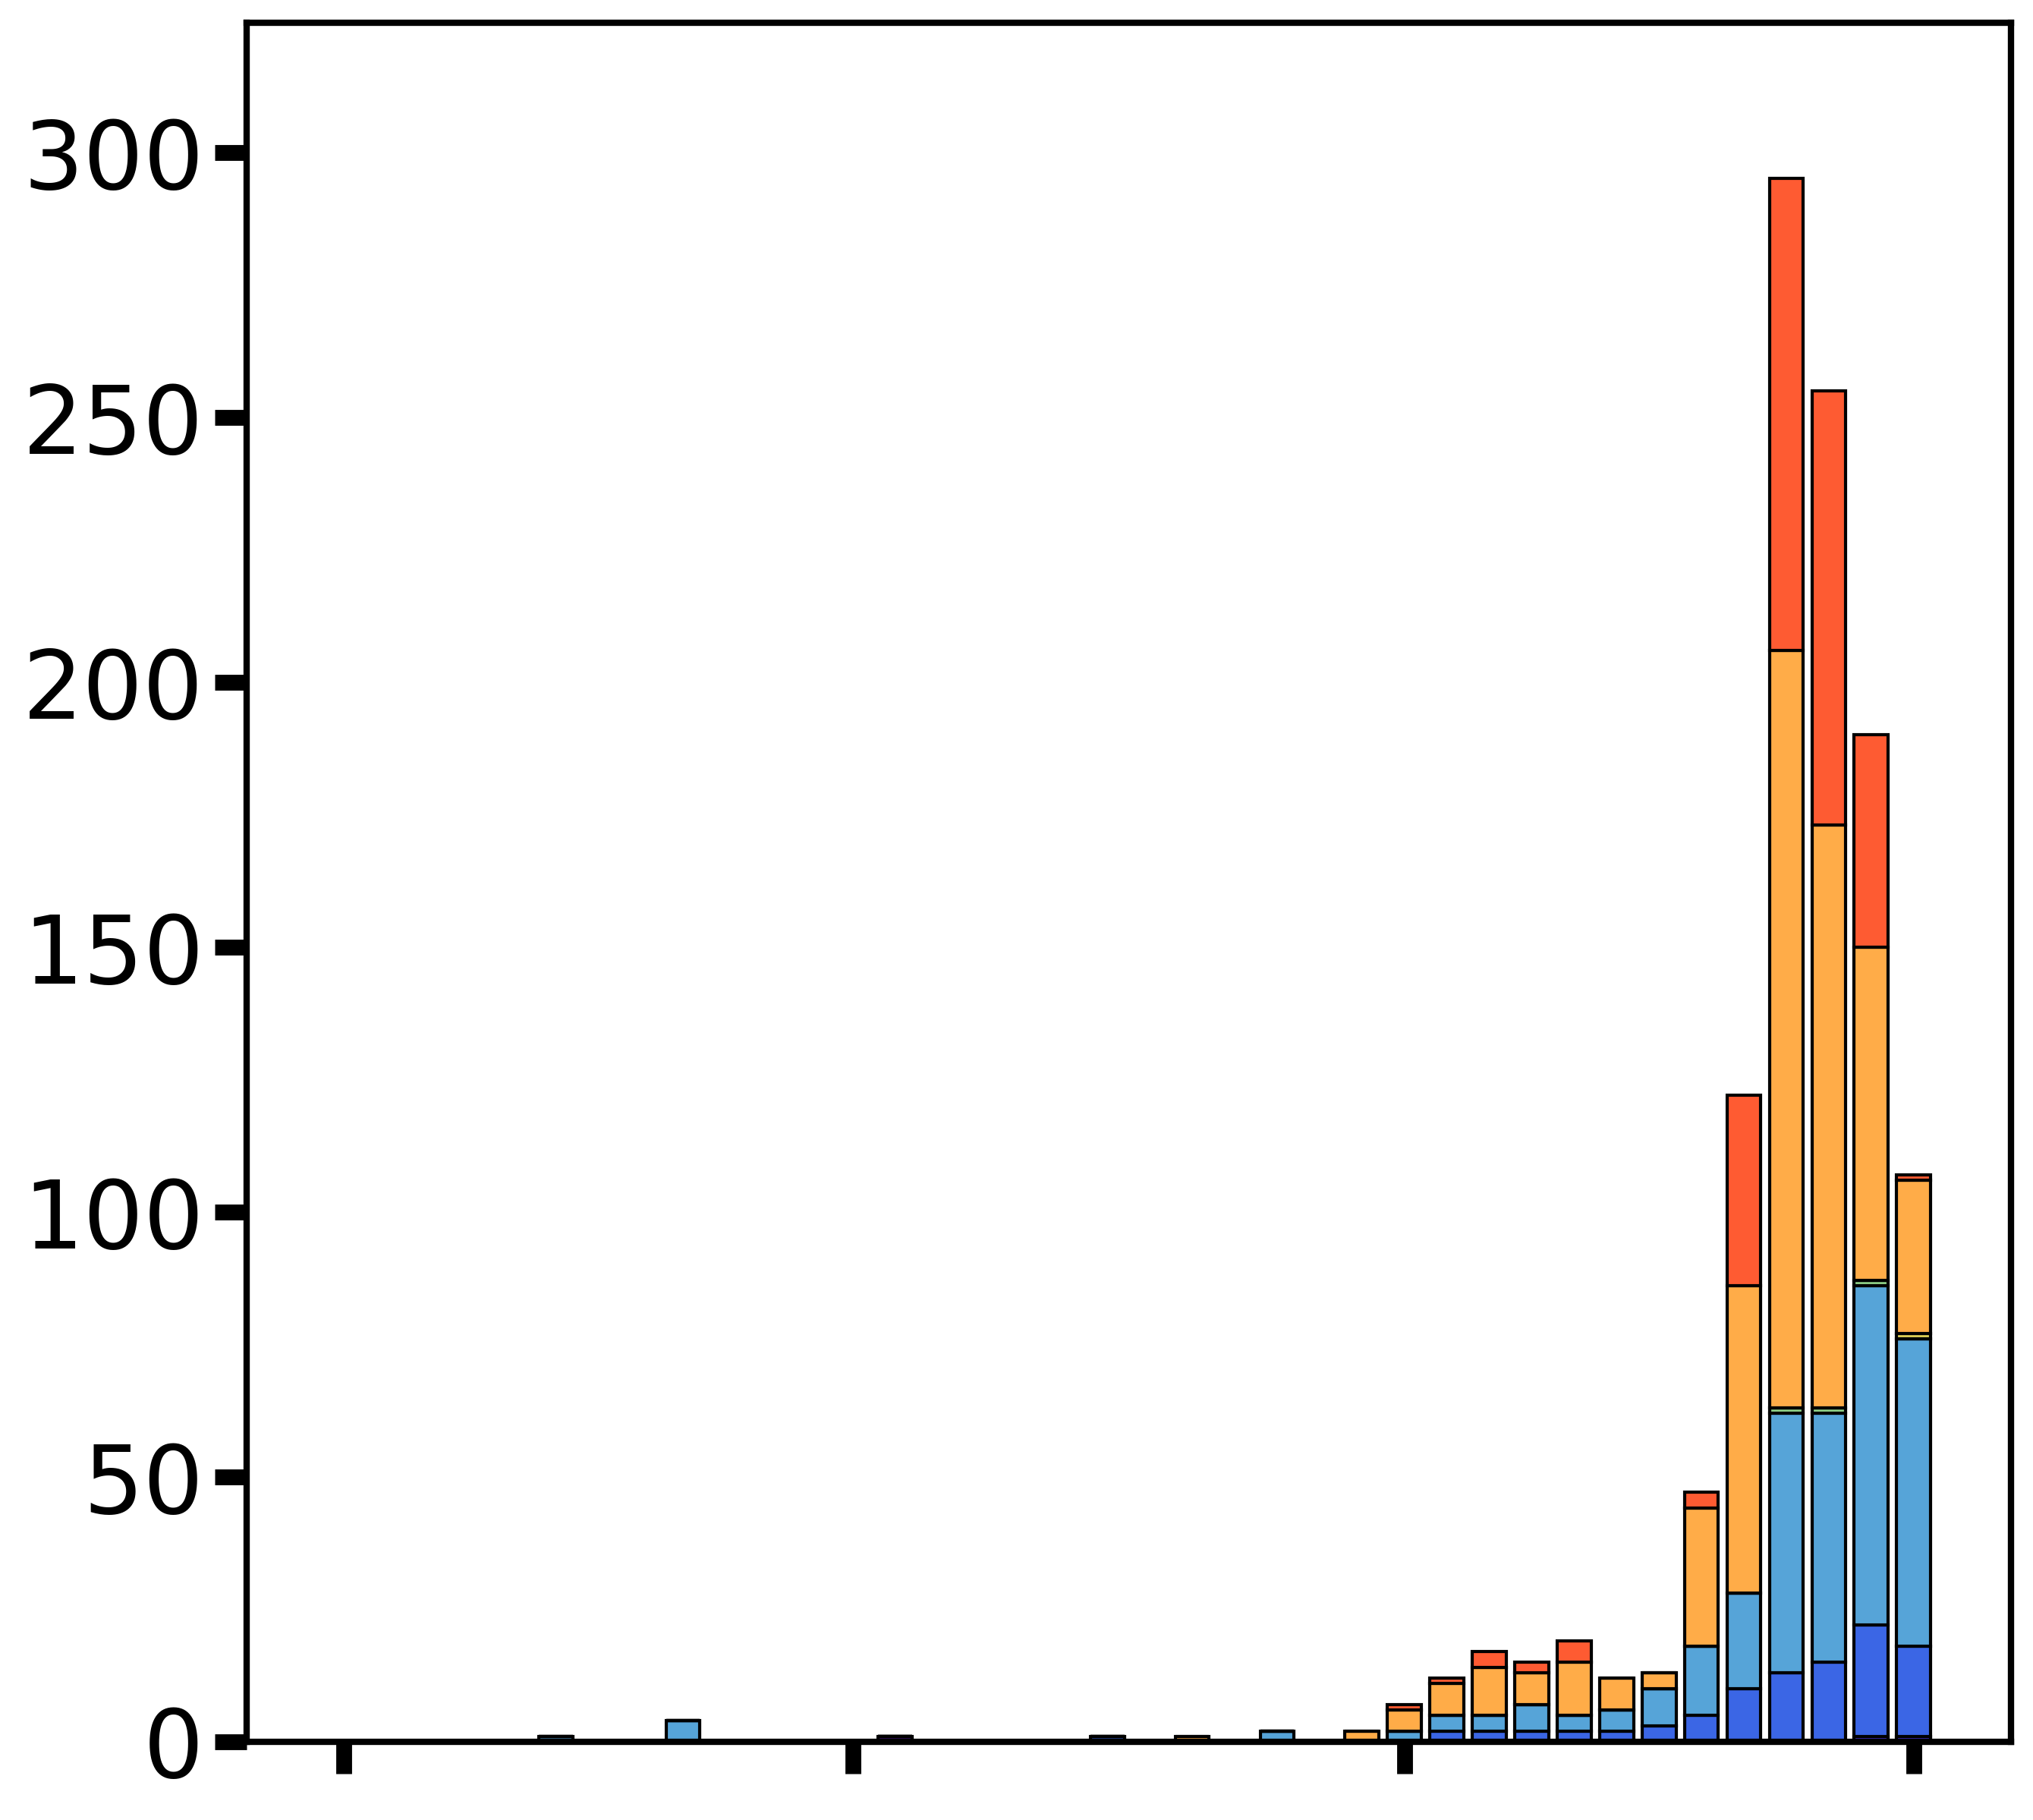

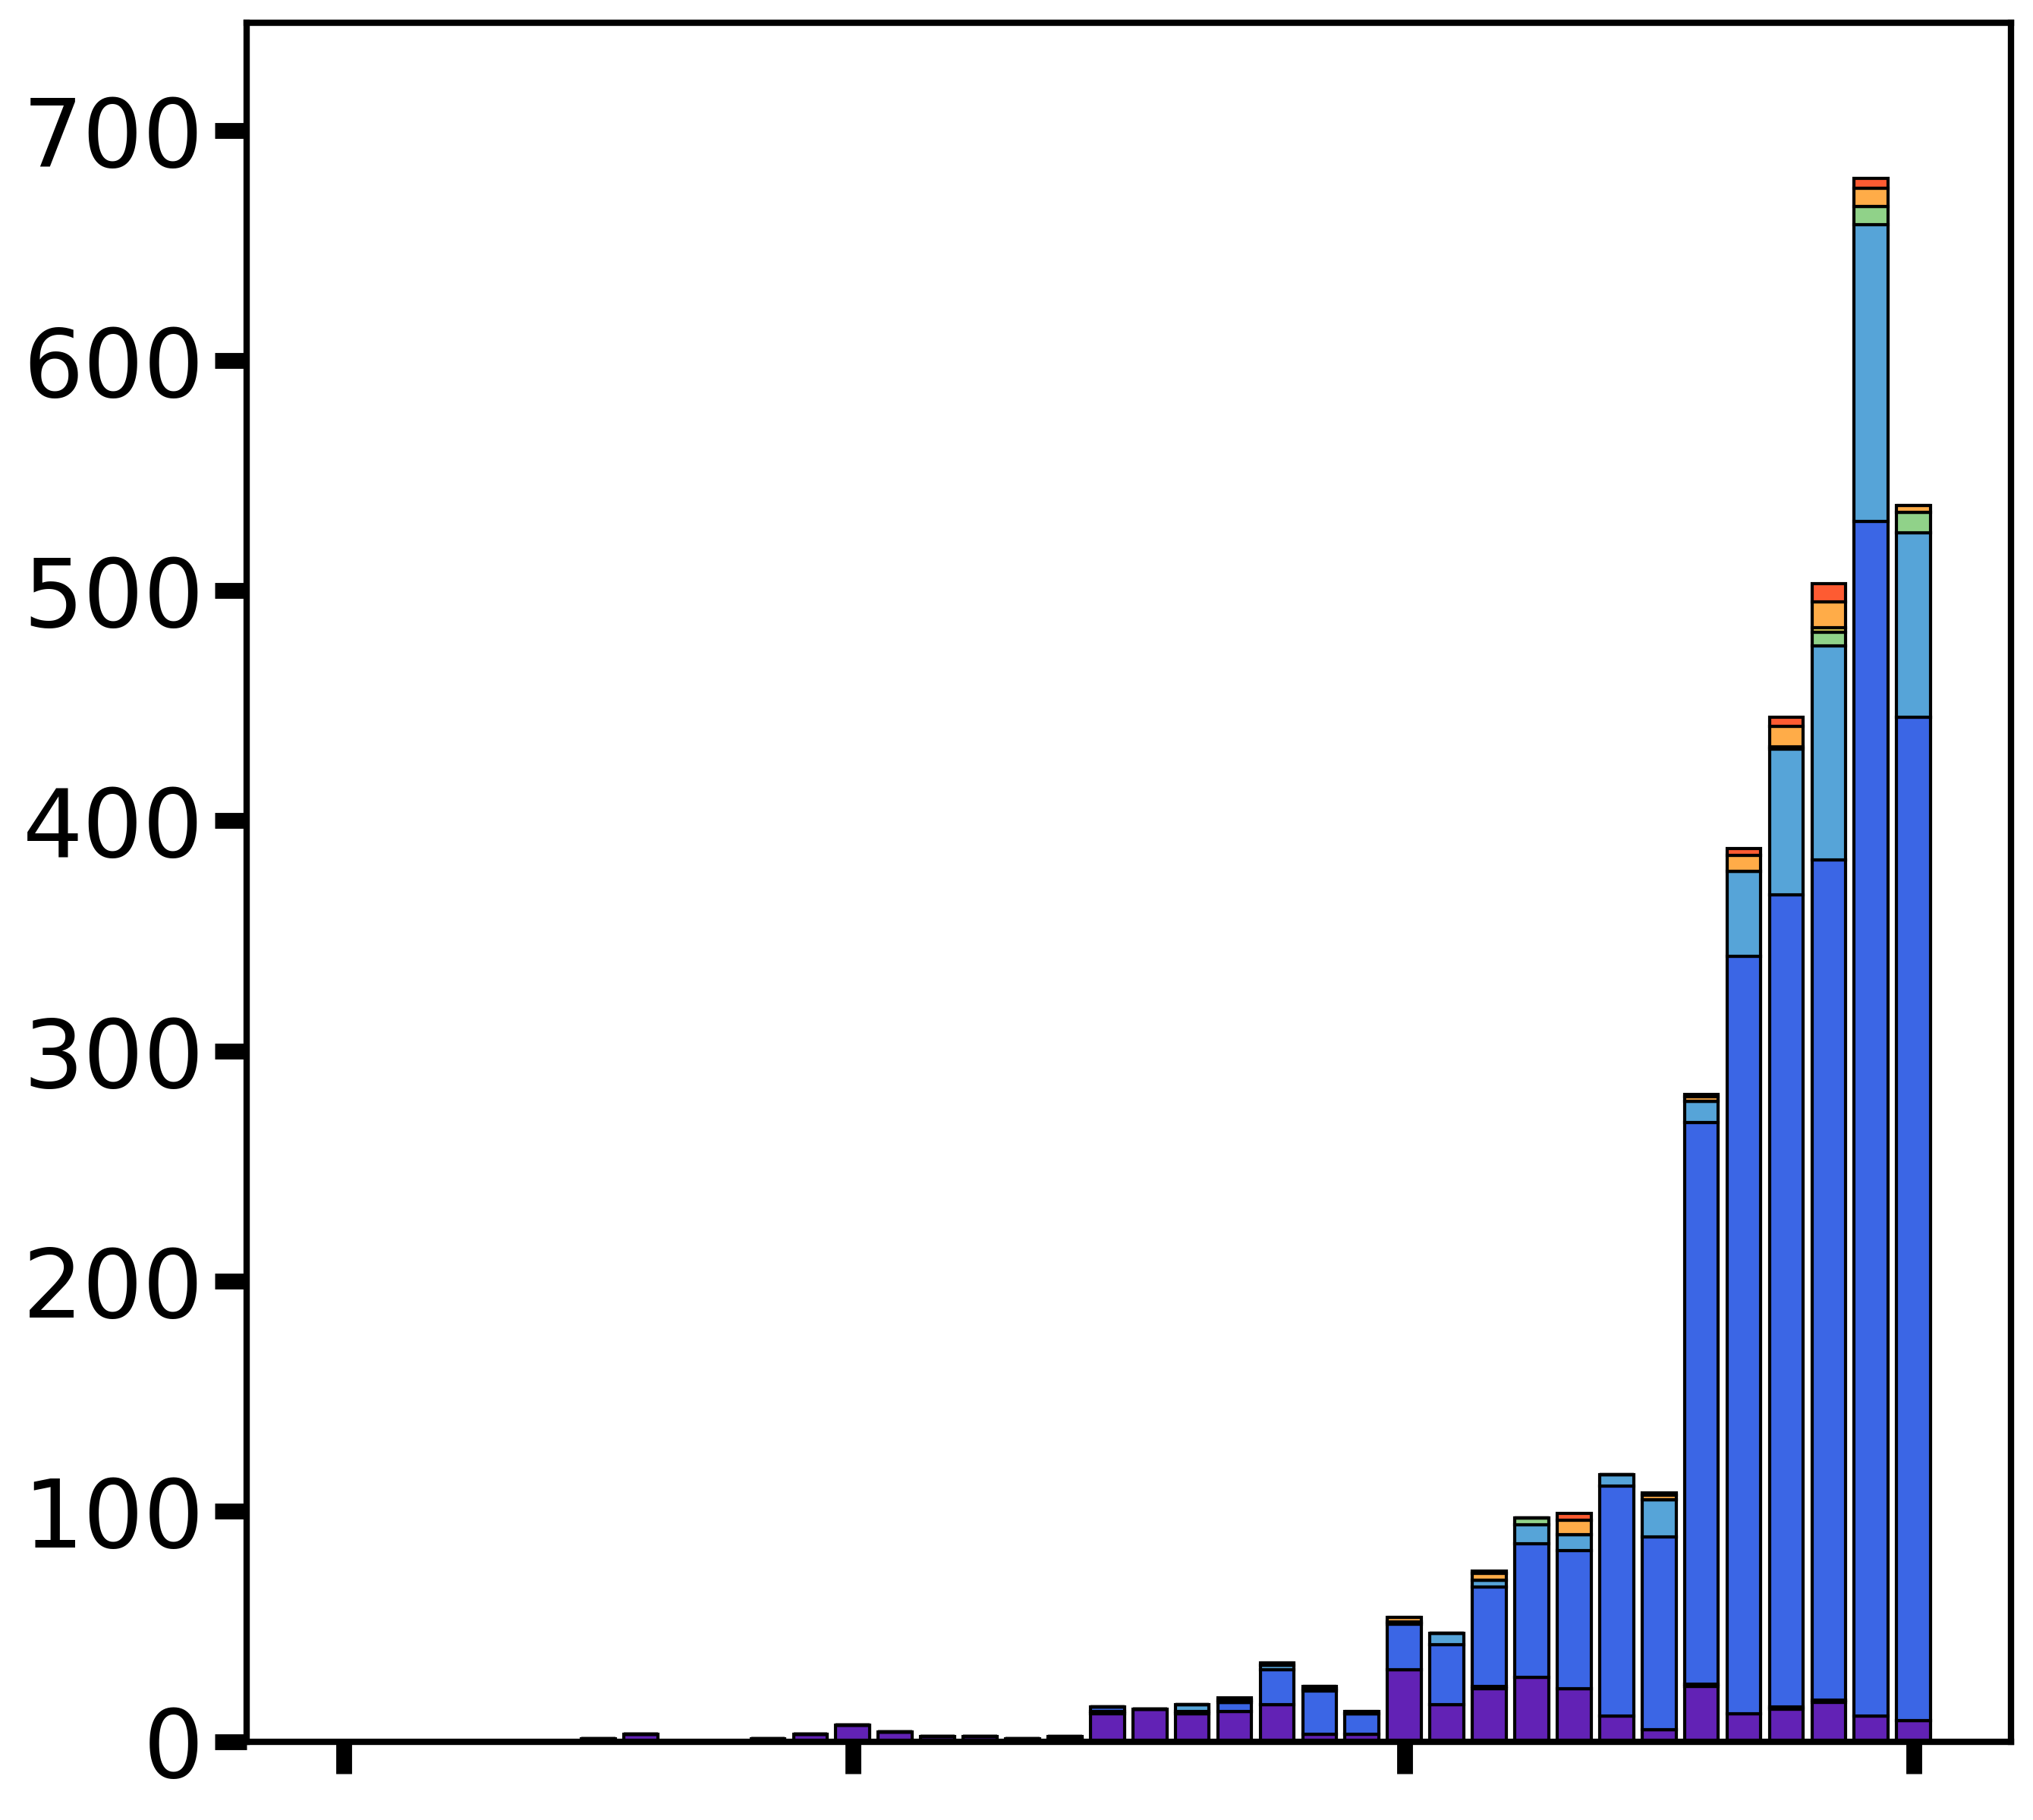

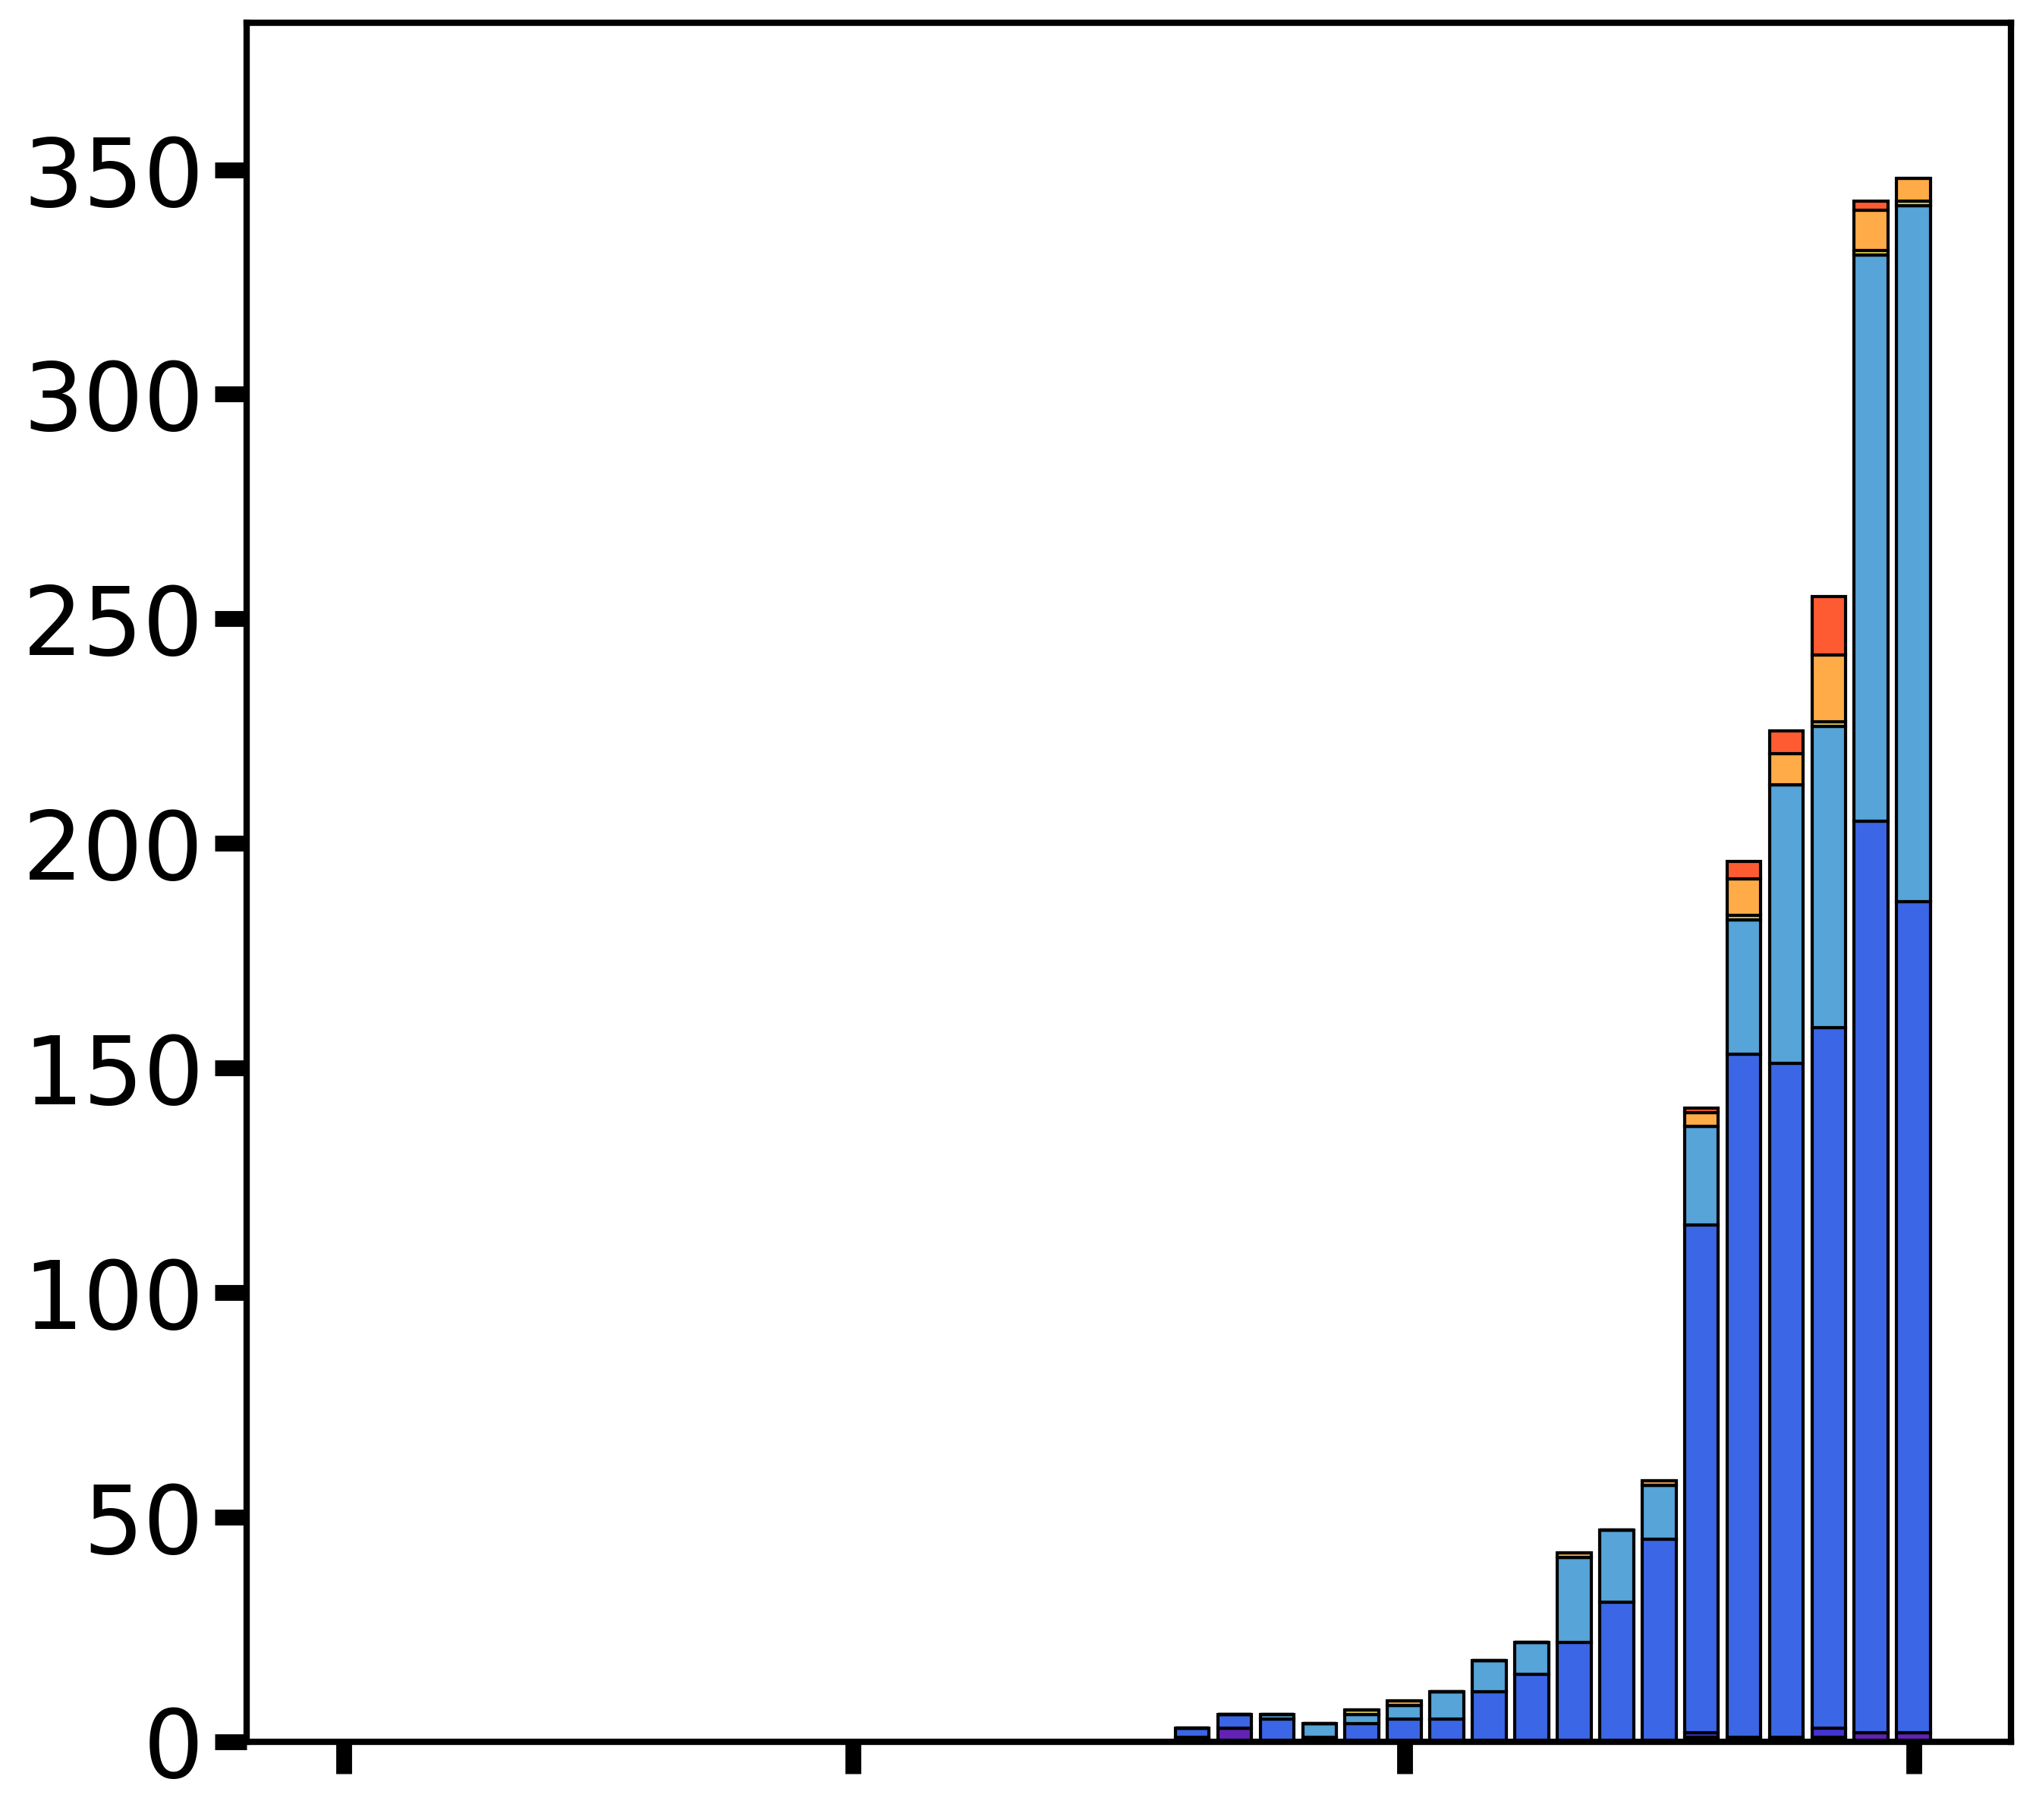

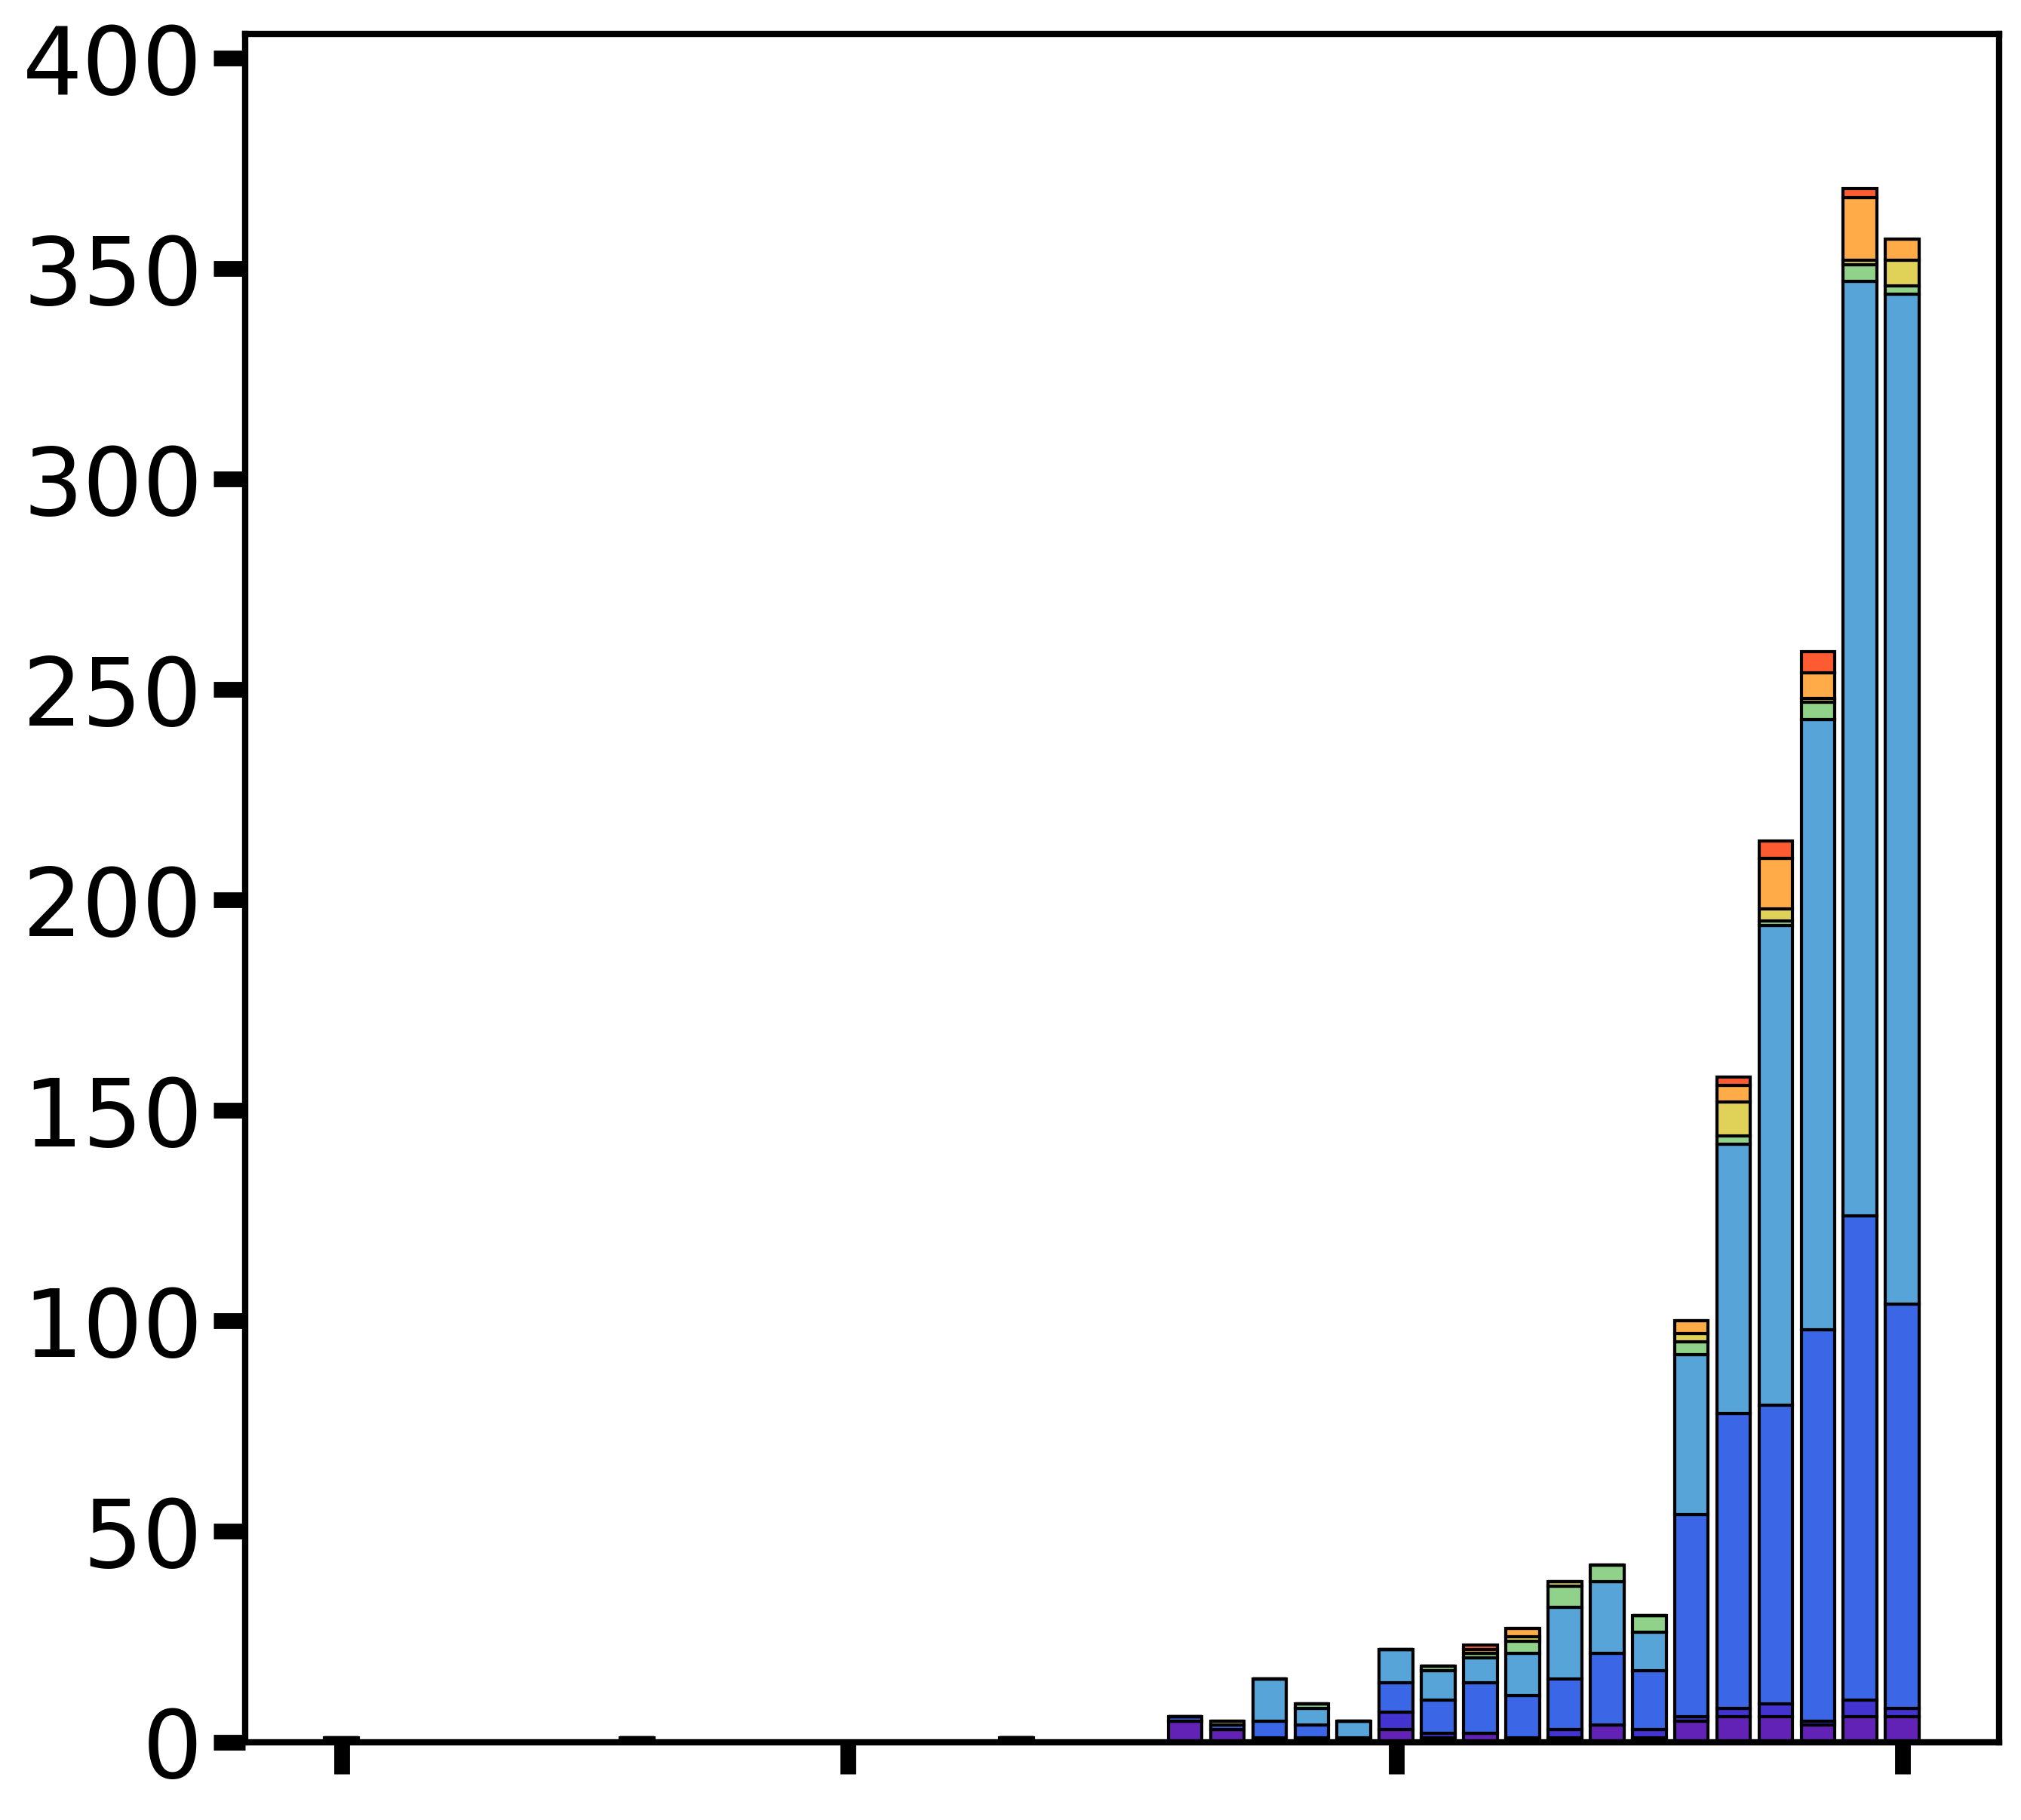

In [34]:
for clade in clades:
    if clade != 'Others':
        submeta = meta_gl[meta_gl.index.isin(clades_gl[clade])]

        dates = [str(i)[:10] for i in pd.date_range('2021-11-04', '2021-12-11')]

        bars = {
            'Africa': [],
            'Asia': [],
            'Europe': [],
            'North America': [],
            'Oceania': [],
            'South America': [],
            'New York State': [],
            'NYC': []
        }

        for b in bars:
            if b != 'NYC':
                if b != 'North America' and b != 'New York State':
                    meta_b = submeta[submeta['region_exposure'] == b]['date'].value_counts()
                elif b == 'North America':
                    meta_b = submeta[(submeta['region_exposure'] == b) & (submeta['division_exposure'] != 'New York')]['date'].value_counts()
                elif b == 'New York State':
                    meta_b = submeta[submeta['division_exposure'] == 'New York']['date'].value_counts()
            else:
                meta_b = meta[meta.index.isin(clades[clade])]['Date of Collection'].value_counts()
            for d in dates:
                if d in meta_b:
                    bars[b].append(meta_b[d])
                else:
                    bars[b].append(0)

        fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)

        cols = {
            'Africa': '#6222B5',
            'Asia': '#4334D2',
            'Europe': '#3B66E5',
            'North America': '#56A4D8',
            'Oceania': '#90D289',
            'South America': '#E0D258',
            'New York State': '#FFAC48',
            'NYC': '#FE5B32'
        }

        b_af = bars['Africa']
        b_as = bars['Asia']
        b_eu = bars['Europe']
        b_na = bars['North America']
        b_oc = bars['Oceania']
        b_sa = bars['South America']
        b_nys = bars['New York State']
        b_nyc = bars['NYC']

        b_12 = np.add(b_af, b_as).tolist()
        b_123 = np.add(b_12, b_eu).tolist()
        b_1234 = np.add(b_123, b_na).tolist()
        b_12345 = np.add(b_1234, b_oc).tolist()
        b_123456 = np.add(b_12345, b_sa).tolist()
        b_1234567 = np.add(b_123456, b_nys).tolist()
        b_12345678 = np.add(b_1234567, b_nyc).tolist()

        plt.bar(dates, b_af, label='Africa', edgecolor='black', color=cols['Africa'])
        plt.bar(dates, b_as, bottom=b_af, label='Asia', edgecolor='black', color=cols['Asia'])
        plt.bar(dates, b_eu, bottom=b_12, label='Europe', edgecolor='black', color=cols['Europe'])
        plt.bar(dates, b_na, bottom=b_123, label='North America', edgecolor='black', color=cols['North America'])
        plt.bar(dates, b_oc, bottom=b_1234, label='Oceania', edgecolor='black', color=cols['Oceania'])
        plt.bar(dates, b_sa, bottom=b_12345, label='South America', edgecolor='black', color=cols['South America'])
        plt.bar(dates, b_nys, bottom=b_123456, label='New York State', edgecolor='black', color=cols['New York State'])
        plt.bar(dates, b_nyc, bottom=b_1234567, label='NYC', edgecolor='black', color=cols['NYC'])

        plt.xticks(['2021-11-04', '2021-11-16', '2021-11-29', '2021-12-11'], [])
        
        plt.ylim([0, max(b_12345678)*1.1])

        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.spines['top'].set_linewidth(2)
        ax.spines['right'].set_linewidth(2)

        plt.tick_params(length=10, width=5)
        
        plt.yticks(fontsize=30)

        plt.savefig('../figures/Figure_2B_Clade'+clade+'.pdf')
